In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import ast


from pprint import pprint

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, join_queries_features
from workloads.recsys.recsys_util import get_features, get_feature_update, predict_rating

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dataset_dir = use_dataset("ml-100k-features")
results_dir = use_results("ml-100k-features")

/data/wooders/ralf-vldb//datasets/ml-100k-features


In [10]:
user_features_path = f"{dataset_dir}/user_features.csv"
movie_features_path = f"{dataset_dir}/movie_features.csv"
ratings_path = f"{dataset_dir}/ratings.csv"
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)
test_data = pd.read_csv(ratings_path)

In [17]:
def evaluate(feature_updates): 

    timestamp_to_ingest_time = dict(zip(feature_updates.timestamp, feature_updates.ingest_time))
    
    # set default features 
    for user_id in user_features.keys(): 
        # concate feature for time 0 
        row = pd.DataFrame({"user_id": user_id, "user_features": [user_features[user_id]], "processing_time": 0})
        feature_updates = pd.concat([feature_updates, row])
    
    # assign query timestamps based of ingest_time of feature timestamps 
    queries_df = pd.DataFrame({
        "user_id": test_data.user_id, 
        "movie_id": test_data.movie_id, 
        "rating": test_data.rating, 
        "timestamp": test_data.timestamp, 
        "processing_time": test_data.timestamp.apply(lambda x: timestamp_to_ingest_time[x] if x in timestamp_to_ingest_time else None)
    })
    queries_df = queries_df.dropna()
    queries_df["query_id"] = queries_df.index
    
    # join queries / features 
    tmp_joined_df = join_queries_features(queries_df, feature_updates, key_field="user_id", time_field="processing_time")
    joined_df = tmp_joined_df.merge(queries_df, on=["query_id", "user_id"], suffixes=("_feature", "_query"))
    
    joined_df["prediction"] = joined_df.apply(
        lambda x: predict_rating(np.array(x["user_features"]), movie_features[x["movie_id"]])
    , axis=1) 
    joined_df["baseline_prediction"] = joined_df.apply(
    lambda x: predict_rating(user_features[x["user_id"]], movie_features[x["movie_id"]])
, axis=1) 
    
    return joined_df

In [ ]:
results = {}  

In [24]:
worker_params = [1, 2, 4, 8]
sleep_params = [0.1]
x = "fifo"

for w in worker_params: 
    for s in sleep_params: 
        
        experiment = f"results_workers_{w}_{x}_learningrate_0.02_userfeaturereg_0.01_sleep_{s}"
        if experiment in results: continue 
        try:
            feature_updates = pd.read_csv(f"{results_dir}/{experiment}.csv")
            feature_updates["user_features"] = feature_updates["user_features"].apply(ast.literal_eval)
        except Exception as e: 
            print(e)
            continue 

        evaluated_df = evaluate(feature_updates)
        results[experiment] = {
            "workers": w, 
            "policy": "fifo", 
            "sleep": s, 
            "feature_df": feature_updates,
            "result_df": evaluated_df  
        }
        

100%|██████████| 49399/49399 [01:01<00:00, 797.06it/s]


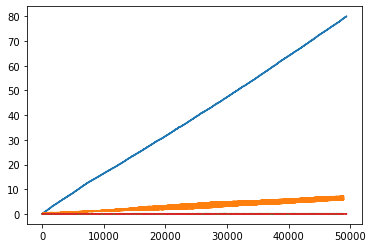

In [25]:
# plot staleness 

for result in results.values(): 
    (result["feature_df"]["processing_time"] - result["feature_df"]["ingest_time"]).plot()

In [48]:

import seaborn as sns
sns.set_theme(style="whitegrid")

In [70]:
errors = [] 
filtered_errors = []
workers = []
scheduler = [] 

scores_df = pd.DataFrame({"workers": [], "MSE": [], "filter": [], "scheduler": []})

for w in worker_params: 
        
    experiment = f"results_workers_{w}_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.1"
    result = results[experiment]["result_df"]

    print("all")
    print(mean_squared_error(result["rating"], result["prediction"]))
    print(mean_squared_error(result["rating"], result["baseline_prediction"]))
    print(mean_squared_error(result["baseline_prediction"], result["prediction"]))
    
    print("filter")
    #result = result[result["processing_time_feature"] > 0]
    result = result[result["timestamp_query"] > 250]
    print(mean_squared_error(result["rating"], result["prediction"]))
    print(mean_squared_error(result["rating"], result["baseline_prediction"]))
    print(mean_squared_error(result["baseline_prediction"], result["prediction"]))
    print()
    
        
    scores_df = pd.concat([scores_df, pd.DataFrame({
        "workers": [w], 
        "MSE": [mean_squared_error(result["rating"], result["baseline_prediction"])],
        "scheduler": ["baseline (no updates)"], 
        "filter": [False]
    })])
        
    scores_df = pd.concat([scores_df, pd.DataFrame({
        "workers": [w], 
        "MSE": [mean_squared_error(result["rating"], result["prediction"])],
        "scheduler": ["fifo-updates"], 
        "filter": [False]
    })])
    
    scores_df = pd.concat([scores_df, pd.DataFrame({
        "workers": [w], 
        "MSE": [mean_squared_error(result["rating"], result["baseline_prediction"])],
        "scheduler": ["baseline (no updates)"], 
        "filter": [True]
    })])
        
    scores_df = pd.concat([scores_df, pd.DataFrame({
        "workers": [w], 
        "MSE": [mean_squared_error(result["rating"], result["prediction"])],
        "scheduler": ["fifo-updates"], 
        "filter": [True]
    })])
    
scores_df

all
0.964697737198647
0.963470348046898
0.0047578915287250995
filter
1.0109722647292514
1.0079093431900432
0.006053658487645059

all
0.9599152410084748
0.963470348046898
0.00833460720133979
filter
1.0051558974199046
1.0079093431900432
0.01063794371522848

all
0.9435428831860567
0.963470348046898
0.021317849768954737
filter
0.9779835389868148
1.0079093431900432
0.028343977110468096

all
0.9505082004928812
0.963470348046898
0.013114610517973486
filter
0.9895898639012385
1.0079093431900432
0.01764252909578948



,workers,MSE,filter,scheduler
0,1.0,1.007909,0.0,baseline (no updates)
0,1.0,1.010972,0.0,fifo-updates
0,1.0,1.007909,1.0,baseline (no updates)
0,1.0,1.010972,1.0,fifo-updates
0,2.0,1.007909,0.0,baseline (no updates)
0,2.0,1.005156,0.0,fifo-updates
0,2.0,1.007909,1.0,baseline (no updates)
0,2.0,1.005156,1.0,fifo-updates
0,4.0,1.007909,0.0,baseline (no updates)
0,4.0,0.977984,0.0,fifo-updates


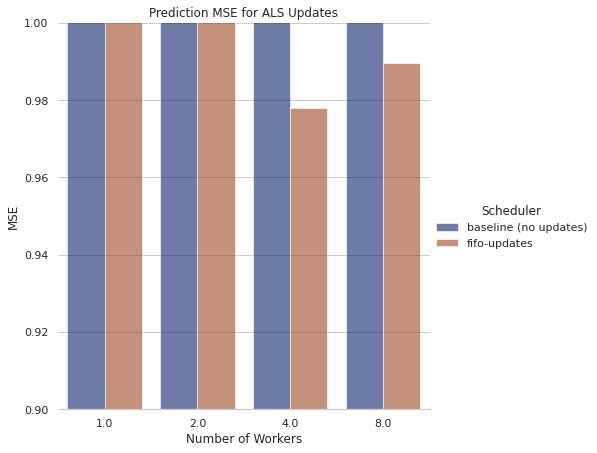

In [71]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scores_df[scores_df["filter"] == 1], kind="bar",
    x="workers", y="MSE", hue="scheduler",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Number of Workers", "MSE")
plt.ylim(0.90, 1)
g.set(title="Prediction MSE for ALS Updates")
g.legend.set_title("Scheduler")

In [38]:
results[key]["result_df"]

,user_id,user_features,ingest_time,timestamp_feature,processing_time_feature,query_id,query_user_id,query_timestamp,movie_id,rating,timestamp_query,processing_time_query,prediction,baseline_prediction
0,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,4599,1.0,1.645683e+09,46,4,46,1.645683e+09,3.020934,3.020934
1,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,4600,1.0,1.645683e+09,177,5,46,1.645683e+09,4.015216,4.015216
2,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,4602,1.0,1.645683e+09,195,5,46,1.645683e+09,4.004723,4.004723
3,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,4604,1.0,1.645683e+09,213,2,46,1.645683e+09,3.704865,3.704865
4,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,4605,1.0,1.645683e+09,218,3,46,1.645683e+09,3.487207,3.487207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49394,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,37291,943.0,1.645683e+09,229,2,372,1.645683e+09,2.807742,2.807742
49395,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,37292,943.0,1.645683e+09,449,1,372,1.645683e+09,2.609130,2.609130
49396,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,37293,943.0,1.645683e+09,234,3,372,1.645683e+09,3.573015,3.573015
49397,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,37294,943.0,1.645683e+09,151,4,372,1.645683e+09,3.491391,3.491391


In [31]:
1/(10/50000)

5000.0

In [39]:
key

'results_workers_1_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.1'

In [41]:
results[key]["feature_df"]

,user_id,user_features,ingest_time,timestamp,processing_time
0,712,"[0.0002096466615135222, 0.00028415484285569106...",1.645683e+09,0,1.645683e+09
1,23,"[0.1551610140794084, 0.05534532873818174, 0.39...",1.645683e+09,0,1.645683e+09
2,23,"[0.1558862970918417, 0.05535640001818538, 0.39...",1.645683e+09,0,1.645683e+09
3,23,"[0.15557652164489713, 0.05555409487916563, 0.3...",1.645683e+09,0,1.645683e+09
4,23,"[0.15682565615687008, 0.056276125762296236, 0....",1.645683e+09,0,1.645683e+09
...,...,...,...,...,...
49369,189,"[0.47163313324145284, 0.168040033012125, 0.576...",1.645683e+09,493,1.645683e+09
49370,189,"[0.47847857034944014, 0.16803789169600616, 0.5...",1.645683e+09,493,1.645683e+09
49371,189,"[0.47831930167041725, 0.16795552192906438, 0.5...",1.645683e+09,493,1.645683e+09
49372,189,"[0.4837641966762788, 0.16991983281024342, 0.58...",1.645683e+09,493,1.645683e+09
